In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

In [2]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

2023-08-18 10:21:44.634487: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-18 10:21:44.634523: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-08-18 10:21:44.634840: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow.keras.layers import Conv2D, Lambda, Activation, MaxPooling2D, \
                                    Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Resizing

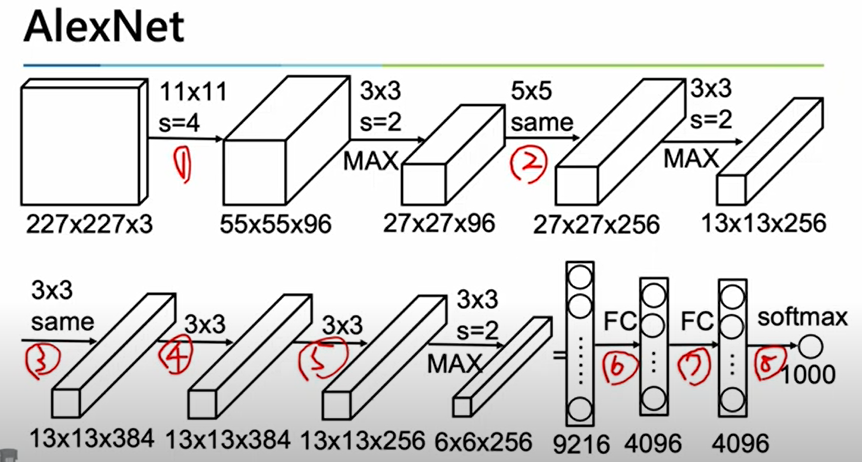

In [4]:
model = models.Sequential()

model.add(Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:]))

model.add(Conv2D(96, 11, strides=4, padding='same'))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))

model.add(Conv2D(256, 5, strides=4, padding='same'))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))

model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, 3, strides=4, padding='same'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(3, strides=2))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 56, 56, 96)        0         
                                                                 
 activation (Activation)     (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         614656    
                                                        

原始模型訓練分拆於2張GPU上進行，因此原始論文圖片分為兩部分(上下)
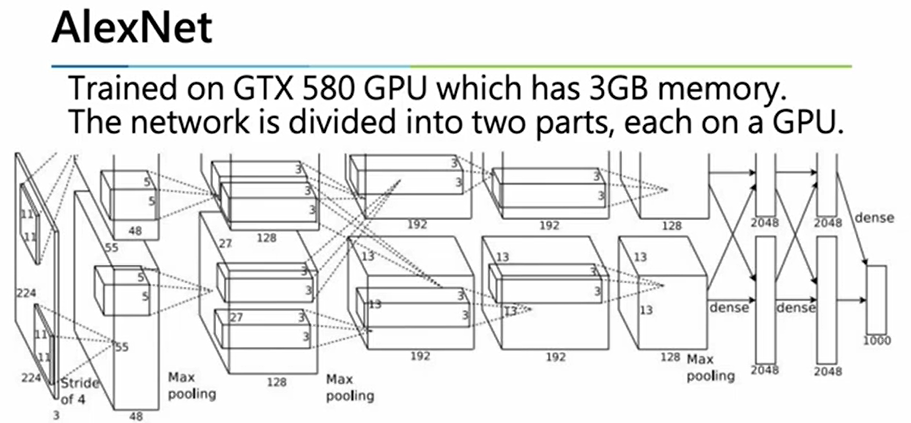

記憶體 \ 參數量 \ 浮點數運算量
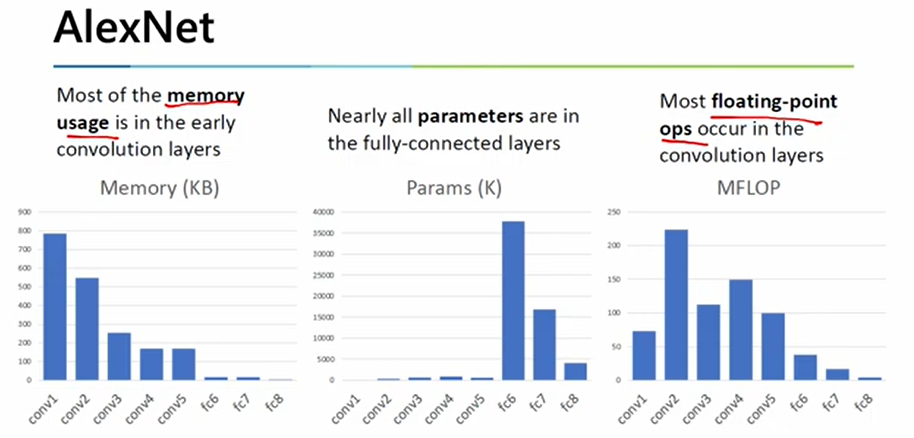


In [ ]:
model.compile(optimizer='adam', 
              loss=losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])
history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(x_val, y_val))

Epoch 1/10
1813/1813 [==============================] - 610s 336ms/step - loss: 2.3020 - accuracy: 0.1105 - val_loss: 2.3019 - val_accuracy: 0.1070
Epoch 2/10
 734/1813 [===========>..................] - ETA: 8:04 - loss: 2.3017 - accuracy: 0.1103

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
model.evaluate(x_test, y_test)